# MS-CELEB Face Recognition

## Importing the libraries


In [66]:
import os
import shutil
import pathlib
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
from PIL import Image
from mtcnn.mtcnn import MTCNN


# to make this notebook's output stable across runs
np.random.seed(42)

# Constants
SIZE_OF_IMAGES = (192, 192)
SIZE_OF_BATCH = 64
DATA_DIR = pathlib.Path('./data/MS_CELEB_20KnownCat/')
MODELS_DIR = pathlib.Path('./models')

print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Functions

In [160]:

def plot_history(history):
    """"Plot the accuracy, loss, precision, recall and AUC \
        curves for training and validation."""

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    auc = history.history["auc"]
    val_auc = history.history["val_auc"]

    precision = history.history["precision"]
    val_precision = history.history["val_precision"]

    recall = history.history["recall"]
    val_recall = history.history["val_recall"]

    epochs = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 12))

    plt.subplot(321)
    plt.plot(epochs, accuracy, "bo", label="Training accuracy")
    plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.grid()

    plt.subplot(322)
    plt.plot(epochs, loss, "bo", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()
    plt.grid()

    plt.subplot(323)
    plt.plot(epochs, precision, "bo", label="Training precision")
    plt.plot(epochs, val_precision, "b", label="Validation precision")
    plt.title("Training and validation precision")
    plt.legend()
    plt.grid()

    plt.subplot(324)
    plt.plot(epochs, recall, "bo", label="Training recall")
    plt.plot(epochs, val_recall, "b", label="Validation recall")
    plt.title("Training and validation recall")
    plt.legend()
    plt.grid()

    plt.subplot(3, 2, (5, 6))
    plt.plot(epochs, auc, "bo", label="Training AUC")
    plt.plot(epochs, val_auc, "b", label="Validation AUC")
    plt.title("Training and validation AUC")
    plt.legend()
    plt.grid()

    plt.show()


def show_eval_results(test_model, test_dataset, labels=None):
    """Evaluate the model on the test dataset and print the results."""

    eval_results = test_model.evaluate(test_dataset, labels)

    print(f"Test loss: {eval_results[0]:.3f}")
    print(f"Test accuracy: {eval_results[1]:.3f}")
    print(f"Test AUC: {eval_results[2]:.3f}")
    print(f"Test Precision: {eval_results[3]:.3f}")
    print(f"Test Recall: {eval_results[4]:.3f}")


def model_evaluation(model, test_images, test_labels, label_dict):
    """Evaluate model performance on test data."""

    (test_loss,
     test_acc,
     test_AUC,
     test_precision,
     test_recall) = model.evaluate(test_images, test_labels)
    print('Test accuracy:', test_acc)
    print('Test loss:', test_loss)
    print('Test AUC:', test_AUC)
    print('Test precision:', test_precision)
    print('Test recall:', test_recall)

    predictions = model.predict(test_images)

    confussion_matrix = tf.math.confusion_matrix(
        labels=test_labels.argmax(axis=1),
        predictions=predictions.argmax(axis=1))

    plt.figure(figsize=(10, 20))
    plt.imshow(confussion_matrix, cmap=plt.cm.Blues)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.xticks(labels=list(label_dict.values()), ticks=list(label_dict.keys()),
               fontsize=4)
    plt.yticks(labels=list(label_dict.values()),
               ticks=list(label_dict.keys()), fontsize=8)
    plt.grid(False)
    plt.show()


## Importing the data

In [63]:
train_dataset = image_dataset_from_directory(DATA_DIR / 'train',
                                             image_size=SIZE_OF_IMAGES,
                                             batch_size=SIZE_OF_BATCH,
                                             label_mode='categorical',
                                             color_mode='rgb',
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)

validation_dataset = image_dataset_from_directory(DATA_DIR / 'train',
                                                  image_size=SIZE_OF_IMAGES,
                                                  batch_size=SIZE_OF_BATCH,
                                                  label_mode='categorical',
                                                  color_mode='rgb',
                                                  validation_split=0.2,
                                                  subset='validation',
                                                  seed=42)



Found 1939 files belonging to 20 classes.
Using 1552 files for training.
Found 1939 files belonging to 20 classes.
Using 387 files for validation.
Found 68 files belonging to 20 classes.


In [48]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (64, 192, 192, 3)
labels batch shape: (64, 20)


## Importing The Mobile Net

In [49]:
conv_base = tf.keras.applications.MobileNetV3Large(
    weights='imagenet', input_shape=(192, 192, 3), include_top=False)
conv_base.trainable = False

In [50]:
conv_base.summary()


Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 192, 192, 3)  0           ['input_15[0][0]']               
                                                                                                  
 Conv (Conv2D)                  (None, 96, 96, 16)   432         ['rescaling_1[0][0]']            
                                                                                                  
 Conv/BatchNorm (BatchNormaliza  (None, 96, 96, 16)  64          ['Conv[0][0]']    

In [51]:
# import keras_cv

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.25),
        layers.RandomZoom(0.1),

    ]
)


In [52]:
inputs = keras.Input(shape=SIZE_OF_IMAGES + (3,))
x = data_augmentation(inputs)
x = keras.applications.mobilenet_v3.preprocess_input(x)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(20, activation='softmax')(x)

model = keras.Model(inputs=inputs,
                    outputs=outputs,
                    name='MobileNet_FeatExtr_DataAugm')

model.summary()

Model: "MobileNet_FeatExtr_DataAugm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 192, 192, 3)]     0         
                                                                 
 sequential_6 (Sequential)   (None, 192, 192, 3)       0         
                                                                 
 MobilenetV3large (Functiona  (None, 6, 6, 960)        2996352   
 l)                                                              
                                                                 
 global_average_pooling2d_7   (None, 960)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_18 (Dense)            (None, 256)               246016    
                                                                 
 dropout_9 (Dropout)         (None, 256

In [53]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy', 'AUC', 'Precision', 'Recall'])

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath=os.path.join(
        MODELS_DIR, 'MobileNetV3_FeatExtr_DataAugmnt.keras'),
        save_best_only=True,
        monitor="val_loss"),
]

history = model.fit(train_dataset,
                    epochs=100,
                    validation_data=validation_dataset,
                    callbacks=callbacks)

Epoch 1/100
25/25 [==============================] - 8s 177ms/step - loss: 2.7908 - accuracy: 0.2655 - auc: 0.7640 - precision: 0.4274 - recall: 0.1347 - val_loss: 1.8429 - val_accuracy: 0.4264 - val_auc: 0.8923 - val_precision: 0.7576 - val_recall: 0.2584
Epoch 2/100
25/25 [==============================] - 3s 132ms/step - loss: 1.6283 - accuracy: 0.5045 - auc: 0.9140 - precision: 0.6987 - recall: 0.3466 - val_loss: 1.4194 - val_accuracy: 0.5659 - val_auc: 0.9389 - val_precision: 0.8103 - val_recall: 0.3643
Epoch 3/100
25/25 [==============================] - 3s 121ms/step - loss: 1.2592 - accuracy: 0.6224 - auc: 0.9487 - precision: 0.7699 - recall: 0.4852 - val_loss: 1.4438 - val_accuracy: 0.5504 - val_auc: 0.9361 - val_precision: 0.6991 - val_recall: 0.3902
Epoch 4/100
25/25 [==============================] - 3s 120ms/step - loss: 1.0836 - accuracy: 0.6656 - auc: 0.9608 - precision: 0.7792 - recall: 0.5548 - val_loss: 1.1664 - val_accuracy: 0.6305 - val_auc: 0.9570 - val_precision: 

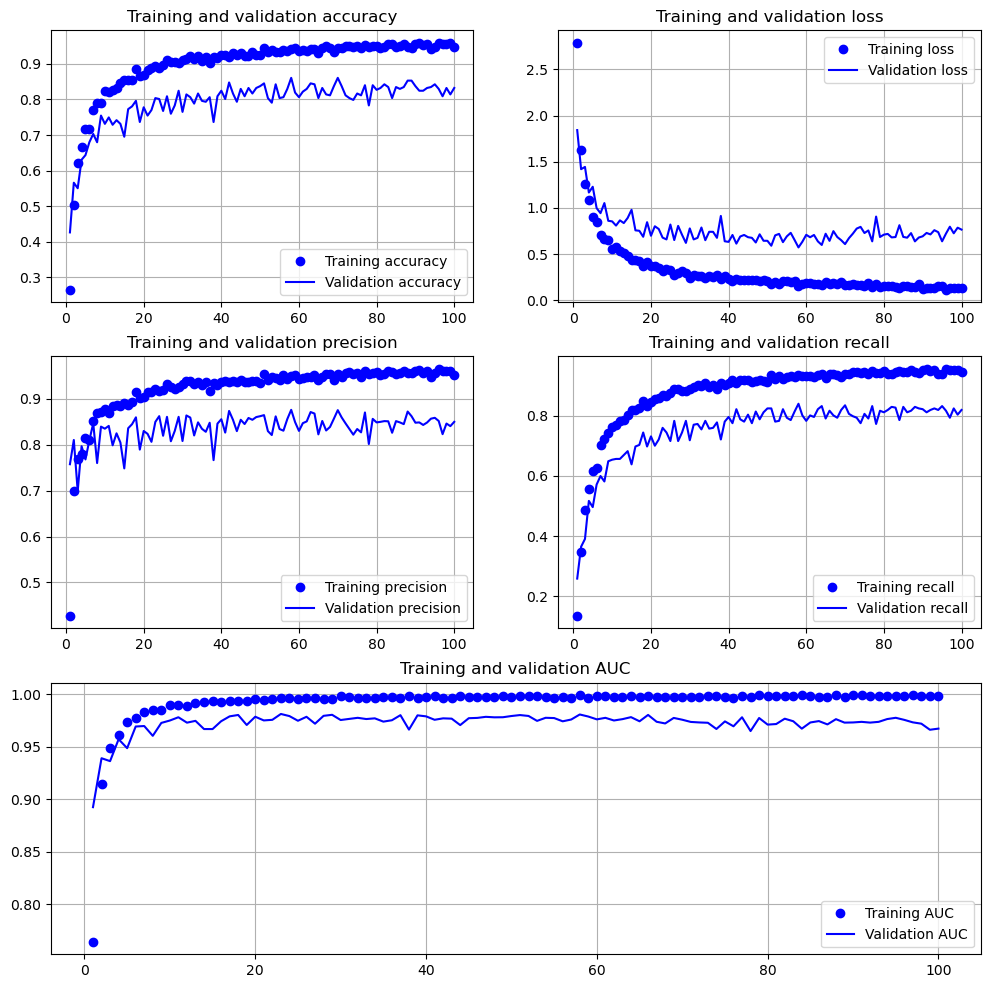

In [54]:
plot_history(history)


In [55]:
show_eval_results(model, validation_dataset)

7/7 [==============================] - 0s 41ms/step - loss: 0.7648 - accuracy: 0.8320 - auc: 0.9671 - precision: 0.8499 - recall: 0.8191
Test loss: 0.765
Test accuracy: 0.832
Test AUC: 0.967
Test Precision: 0.850
Test Recall: 0.819


## Fine-tunning the pre-trained model

In [56]:
conv_base.trainable = True
for layer in conv_base.layers[:-14]:
    layer.trainable = False


In [57]:
conv_base.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 192, 192, 3)  0           ['input_15[0][0]']               
                                                                                                  
 Conv (Conv2D)                  (None, 96, 96, 16)   432         ['rescaling_1[0][0]']            
                                                                                                  
 Conv/BatchNorm (BatchNormaliza  (None, 96, 96, 16)  64          ['Conv[0][0]']    

### Excluding batch normalization layers

In [58]:
for layer in conv_base.layers[-14:]:
    if isinstance(layer, (layers.BatchNormalization,)):
        print(layer.name)
        layer.trainable = False


expanded_conv_14/project/BatchNorm
Conv_1/BatchNorm


In [59]:
conv_base.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 192, 192, 3)  0           ['input_15[0][0]']               
                                                                                                  
 Conv (Conv2D)                  (None, 96, 96, 16)   432         ['rescaling_1[0][0]']            
                                                                                                  
 Conv/BatchNorm (BatchNormaliza  (None, 96, 96, 16)  64          ['Conv[0][0]']    

In [60]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy', 'AUC', 'Precision', 'Recall'])

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath=os.path.join(
        MODELS_DIR, 'MobileNetV3_FineTunned.keras'),
        save_best_only=True,
        monitor="val_loss"),
]

history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=validation_dataset,
                    callbacks=callbacks)


Epoch 1/50
25/25 [==============================] - 8s 172ms/step - loss: 0.4994 - accuracy: 0.8943 - auc: 0.9852 - precision: 0.9008 - recall: 0.8892 - val_loss: 0.7033 - val_accuracy: 0.8165 - val_auc: 0.9784 - val_precision: 0.8427 - val_recall: 0.8165
Epoch 2/50
25/25 [==============================] - 3s 124ms/step - loss: 0.2452 - accuracy: 0.9201 - auc: 0.9949 - precision: 0.9281 - recall: 0.9143 - val_loss: 0.7067 - val_accuracy: 0.8346 - val_auc: 0.9741 - val_precision: 0.8431 - val_recall: 0.8191
Epoch 3/50
25/25 [==============================] - 3s 118ms/step - loss: 0.1119 - accuracy: 0.9639 - auc: 0.9981 - precision: 0.9694 - recall: 0.9607 - val_loss: 0.7683 - val_accuracy: 0.8346 - val_auc: 0.9667 - val_precision: 0.8515 - val_recall: 0.8295
Epoch 4/50
25/25 [==============================] - 3s 122ms/step - loss: 0.1677 - accuracy: 0.9439 - auc: 0.9977 - precision: 0.9499 - recall: 0.9407 - val_loss: 0.6311 - val_accuracy: 0.8605 - val_auc: 0.9793 - val_precision: 0.86

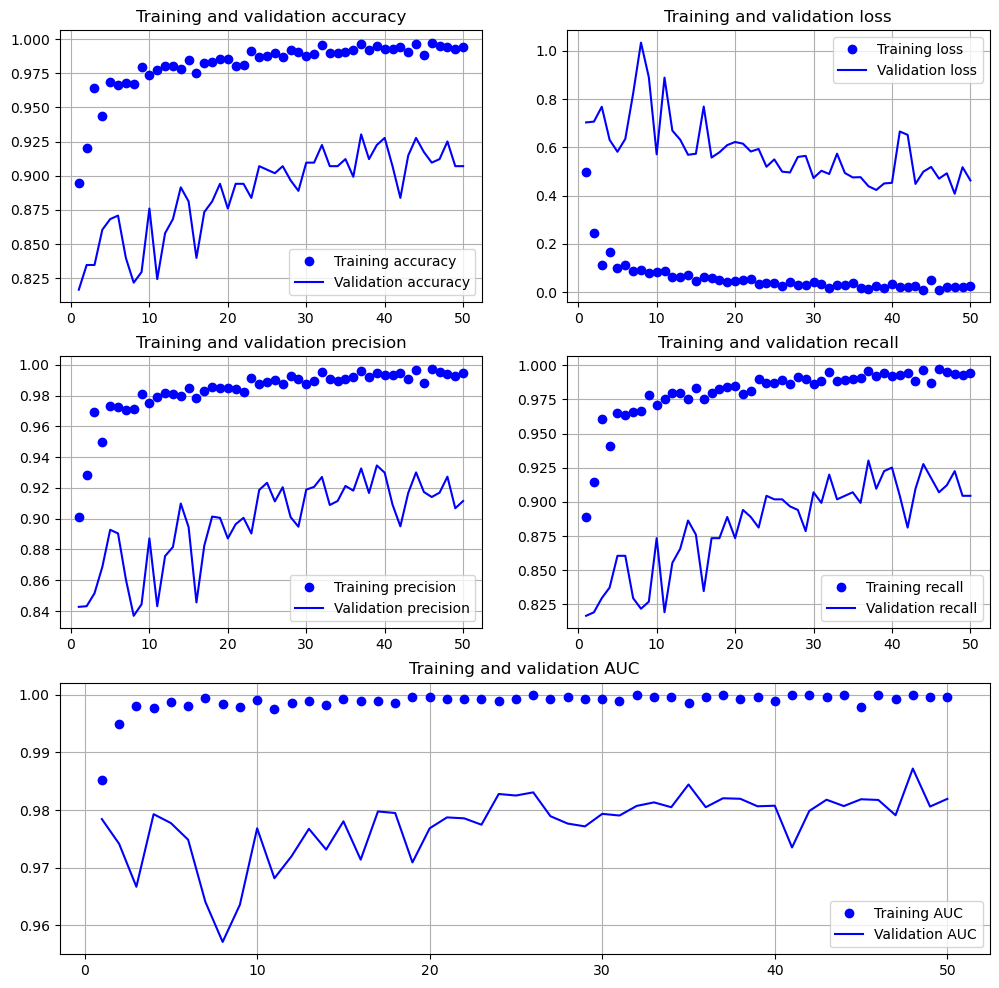

In [61]:
plot_history(history)


In [62]:
show_eval_results(model, validation_dataset)


7/7 [==============================] - 1s 40ms/step - loss: 0.4631 - accuracy: 0.9070 - auc: 0.9819 - precision: 0.9115 - recall: 0.9044
Test loss: 0.463
Test accuracy: 0.907
Test AUC: 0.982
Test Precision: 0.911
Test Recall: 0.904


## Face Detection and Saving the Faces

In [102]:

def extract_face(filename, required_size=SIZE_OF_IMAGES):
    # # load image from file
    pixels = plt.imread(filename)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array


In [105]:
for folder in os.listdir(DATA_DIR / 'test'):
    for file in os.listdir(DATA_DIR / 'test' / folder):
        pixels = extract_face(DATA_DIR / 'test' / folder / file)
        os.makedirs(DATA_DIR / 'test_cropped' / folder, exist_ok=True)
        plt.imsave(DATA_DIR / 'test_cropped' / folder / file, pixels)

1/1 [==============================] - 0s 169ms/step


In [106]:
test_dataset_cropped = image_dataset_from_directory(DATA_DIR / 'test_cropped',
                                            image_size=SIZE_OF_IMAGES,
                                            batch_size=SIZE_OF_BATCH,
                                            label_mode='categorical',
                                            color_mode='rgb',
                                            seed=42)

Found 68 files belonging to 20 classes.


In [107]:
show_eval_results(model, test_dataset_cropped)


2/2 [==============================] - 1s 573ms/step - loss: 1.9036 - accuracy: 0.6765 - auc: 0.9193 - precision: 0.6769 - recall: 0.6471
Test loss: 1.904
Test accuracy: 0.676
Test AUC: 0.919
Test Precision: 0.677
Test Recall: 0.647


In [132]:
test_images = []
test_labels = []
for data_batch, labels_batch in test_dataset_cropped:
    for image, label in zip(data_batch, labels_batch):
        test_images.append(image)
        test_labels.append(label)

In [135]:
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [148]:
label_dict = {v: k for k, v in zip(test_dataset_cropped.class_names, range(20))}

3/3 [==============================] - 0s 38ms/step - loss: 1.9043 - accuracy: 0.6765 - auc: 0.9194 - precision: 0.6769 - recall: 0.6471
Test accuracy: 0.6764705777168274
Test loss: 1.9042816162109375
Test AUC: 0.9193564653396606
Test precision: 0.6769230961799622
Test recall: 0.6470588445663452
3/3 [==============================] - 0s 38ms/step


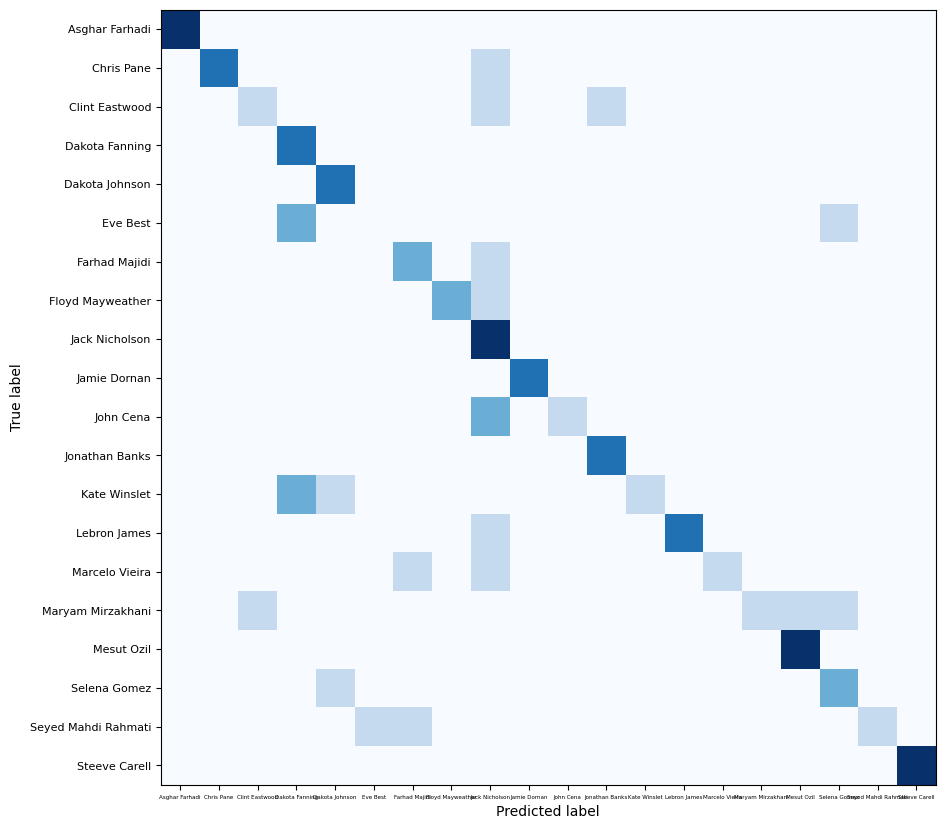

In [161]:
model_evaluation(model, test_images, test_labels, label_dict)